In [398]:
import pandas as pd
import csv
import numpy as np
from io import StringIO
import requests
from google.cloud import bigquery, storage
from sklearn.metrics.pairwise import haversine_distances
import seaborn as sns
import matplotlib.pyplot as plt

In [399]:
PROJECT_ID = 'lon-trans-streaming-pipeline'

# BigQuery Configuration
BQ_client = bigquery.Client(project=PROJECT_ID)
DATA_SET = 'bus_density_streaming_pipeline'

# Cloud storage configuration
Storage_client = storage.Client(project=PROJECT_ID)
DESTINATION_BUCKET = 'arrivals_data'
DESTINATION_PATH =  f"temporary/arrivals_most_recent_snapshot.csv"
bucket = Storage_client.bucket(DESTINATION_BUCKET)
blob = bucket.blob(DESTINATION_PATH)

In [400]:
# Read Clusters Table

cluster_stations_table = 'stopspoint_coordinates_aggloclusters_enriched'

query = f"""
    SELECT *
    FROM `{PROJECT_ID}.{DATA_SET}.{cluster_stations_table}`
"""
result =  BQ_client.query(query)


clusterized_stations_df = pd.DataFrame([{'naptanId': row[0],
                                         'commonName': row[1],
                                         'latitude': row[2],
                                         'longitude': row[3],
                                         'clusterAgglomerative': row[4]} 
                                         for row in result])

In [401]:
clusterized_stations_df.head()

,naptanId,commonName,latitude,longitude,clusterAgglomerative
0,490023111N,Athole Gardens,51.64310,-0.07407,0
1,490023113N,Austin Court,51.64491,-0.07600,0
2,490023113W,Austin Court,51.64491,-0.07600,0
3,490003547W,Baker Street,51.66343,-0.07834,0
4,490003547E1,Baker Street,51.66343,-0.07834,0


In [402]:
# BUS ARRIVALS API CALL
arrivals_url = "https://api.tfl.gov.uk/Mode/bus/Arrivals"
app_key = '132c49c6367b496ba654bc8092f0610a'
url_append = f'?app_key={app_key}' 

arrivals_response = requests.get(arrivals_url + url_append)
arrivals_response_status_code = arrivals_response.status_code

if arrivals_response_status_code == 200:
    arrivals_pred_df = pd.DataFrame(arrivals_response.json())
else:
    print('No Data due to errors')

In [403]:
pd.set_option('display.max_columns', None)
arrivals_pred_df.head()

,$type,id,operationType,vehicleId,naptanId,stationName,lineId,lineName,platformName,direction,bearing,tripId,baseVersion,destinationNaptanId,destinationName,timestamp,timeToStation,currentLocation,towards,expectedArrival,timeToLive,modeName,timing
0,"Tfl.Api.Presentation.Entities.Prediction, Tfl....",1748211419,2,LG71DSV,490010374A,North Greenwich Station,180,180,A,inbound,75,346580,20250704,,"Erith, Fraser Road",2025-07-16T20:47:19.322306Z,1,,null,2025-07-16T20:47:20Z,1970-01-01T00:00:00Z,bus,{'$type': 'Tfl.Api.Presentation.Entities.Predi...
1,"Tfl.Api.Presentation.Entities.Prediction, Tfl....",-35217493,2,YW19VUC,490000242U,Upminster Station,346,346,U,outbound,195,474355,20250704,,Upminster Park Estate,2025-07-16T20:47:19.322306Z,6,,Cranham Or Hornchurch,2025-07-16T20:47:25Z,1970-01-01T00:00:00Z,bus,{'$type': 'Tfl.Api.Presentation.Entities.Predi...
2,"Tfl.Api.Presentation.Entities.Prediction, Tfl....",-291729465,2,SN17MLL,490008822W,Kingston Hill Avenue,362,362,D,outbound,223,355846,20250704,,"Goodmayes, King George Hospital",2025-07-16T20:47:19.322306Z,8,,Chadwell Heath,2025-07-16T20:47:27Z,1970-01-01T00:00:00Z,bus,{'$type': 'Tfl.Api.Presentation.Entities.Predi...
3,"Tfl.Api.Presentation.Entities.Prediction, Tfl....",386888140,2,LX11BCU,490004623D,Burnway,165,165,EA,inbound,356,144577,20250704,,"Romford, The Brewery",2025-07-16T20:47:19.322306Z,1652,,Harold Wood Or Romford,2025-07-16T21:14:51Z,1970-01-01T00:00:00Z,bus,{'$type': 'Tfl.Api.Presentation.Entities.Predi...
4,"Tfl.Api.Presentation.Entities.Prediction, Tfl....",422048768,2,SK20BBJ,490000004W,Aldgate East Station,25,25,J,outbound,239,544782,20250704,,"City Thameslink, Holborn Viaduct",2025-07-16T20:47:19.322306Z,1690,,"Bank, Tower Hill Or Liverpool Street",2025-07-16T21:15:29Z,1970-01-01T00:00:00Z,bus,{'$type': 'Tfl.Api.Presentation.Entities.Predi...


In [404]:
# Enrich data with coordinates and clusters

arrivals_pred_df_enriched = arrivals_pred_df[['vehicleId', 'naptanId', 'lineId', 'timestamp', 'timeToStation']].\
    merge(clusterized_stations_df[['naptanId', 'latitude','longitude', 'clusterAgglomerative']], how='left', on='naptanId')
    # dropna(subset='clusterAgglomerative')

arrivals_pred_df_enriched.sort_values(by='vehicleId')

,vehicleId,naptanId,lineId,timestamp,timeToStation,latitude,longitude,clusterAgglomerative
3603,BD13OHV,490013797N,18,2025-07-16T20:47:19.322306Z,110,51.549860,-0.281640,93.0
7147,BD13OHV,490014378M,18,2025-07-16T20:47:19.322306Z,262,51.553650,-0.292140,83.0
12241,BD13OHV,490001282N,18,2025-07-16T20:47:19.322306Z,655,51.554166,-0.314914,83.0
2142,BD13OHV,490006871N,18,2025-07-16T20:47:19.322306Z,57,51.548450,-0.278490,93.0
6446,BD13OHV,490015558W2,18,2025-07-16T20:47:19.322306Z,229,51.553650,-0.289980,83.0
...,...,...,...,...,...,...,...,...
9912,YY67UUR,490015365C,79,2025-07-16T20:47:19.322306Z,432,51.585590,-0.282370,95.0
7386,YY67UUR,490013367N2,79,2025-07-16T20:47:19.322306Z,274,51.580980,-0.286140,95.0
4913,YY67UUR,490008729E,79,2025-07-16T20:47:19.322306Z,162,51.577280,-0.292180,83.0
10489,YY67UUR,490011531N,79,2025-07-16T20:47:19.322306Z,477,51.588870,-0.283780,95.0


In [405]:
# fetch data points that were not found since coordinates havent been assigned to a cluster yet 

not_found_naptan_df = arrivals_pred_df_enriched[arrivals_pred_df_enriched['clusterAgglomerative'].isnull()]
not_found_naptan_df = not_found_naptan_df[not_found_naptan_df['naptanId'] != 'null'][['vehicleId', 'naptanId', 'lineId', 'timestamp', 'timeToStation']]

if len(not_found_naptan_df) > 0:
    # Remove them from the enrieched data frame -> They will be appended later
    arrivals_pred_df_enriched = arrivals_pred_df_enriched[~arrivals_pred_df_enriched['naptanId'].isin([n for n in not_found_naptan_df['naptanId']])]

    # Read raw coordinates table to estimate cluster based on haversine_distances

    # not_found_naptan_list = list(not_found_naptan_df['naptanId'])
    
    stations_raw_table = 'stopspoint_coordinates'

    raw_stations_coorsinates_query = f"""
        SELECT *
        FROM `{PROJECT_ID}.{DATA_SET}.{stations_raw_table}`
        WHERE naptanId IN {tuple([n for n in not_found_naptan_df['naptanId']])}
    """
    raw_stations_coorinates_result =  BQ_client.query(raw_stations_coorsinates_query)

    raw_stations_coorinates_df = pd.DataFrame([{'naptanId': row[0], 'commonName': row[1], 'latitude': row[2], 'longitude': row[3]} for row in raw_stations_coorinates_result])

    # Apply haversine_distances to each not found coordinate

    clustered_coords = np.radians(clusterized_stations_df[['latitude', 'longitude']].values)
    cluster_labels = clusterized_stations_df['clusterAgglomerative'].values

    proximity_clusters = [] 

    for i in range(0,len(raw_stations_coorinates_df)):
    
        latitude = raw_stations_coorinates_df.iloc[i]['latitude']
        longitude = raw_stations_coorinates_df.iloc[i]['longitude']

        # New point (also in radians)

        new_point = np.radians([[latitude,longitude]])

        # Compute distances to all points
        distances = haversine_distances(clustered_coords, new_point) * 6371.0088  # km

        # Find the closest point and append to list of proximity clusters
        closest_index = np.argmin(distances)
        closest_cluster = cluster_labels[closest_index]

        proximity_clusters.append(closest_cluster)

        # print(f"Closest cluster: {closest_cluster}")

    raw_stations_coorinates_df['clusterAgglomerative'] = proximity_clusters

    # Now merge with not found naptan Ids:
    not_found_naptan_df_enriched = not_found_naptan_df.merge(raw_stations_coorinates_df[['naptanId', 'latitude'	, 'longitude', 'clusterAgglomerative']], how='left', on='naptanId')

    # Append the naptans with enriched data to the original data frame
    final_arrivals_pred_df_enriched = pd.concat([arrivals_pred_df_enriched, not_found_naptan_df_enriched], axis=0, ignore_index=True)

    # Finally, Drop null values in the final enriched in the data frame --> If not found after harvesine proximity that means they are not in the raw coordinates table 

    final_arrivals_pred_df_enriched = final_arrivals_pred_df_enriched.dropna(subset='clusterAgglomerative')
    final_arrivals_pred_df_enriched = final_arrivals_pred_df_enriched [['vehicleId', 'naptanId', 'timeToStation', 'latitude', 'longitude', 'clusterAgglomerative']]

else:
    final_arrivals_pred_df_enriched  =  arrivals_pred_df_enriched
    

In [406]:
print(final_arrivals_pred_df_enriched.shape)
final_arrivals_pred_df_enriched.head()

(15660, 6)


,vehicleId,naptanId,timeToStation,latitude,longitude,clusterAgglomerative
0,LG71DSV,490010374A,1,51.500474,0.004295,40.0
1,YW19VUC,490000242U,6,51.559380,0.250590,103.0
2,SN17MLL,490008822W,8,51.589920,0.137400,98.0
3,LX11BCU,490004623D,1652,51.566550,0.220030,74.0
4,SK20BBJ,490000004W,1690,51.514650,-0.073210,7.0


In [407]:
# Check if we have nulls in final enriched df 

final_arrivals_pred_df_enriched[final_arrivals_pred_df_enriched['clusterAgglomerative'].isnull()]

,vehicleId,naptanId,timeToStation,latitude,longitude,clusterAgglomerative


In [408]:
# Send the most recent data to GCS Temporary file --> IWill copy into official file after extraction and enrichment is complete
csv_buffer = StringIO()
final_arrivals_pred_df_enriched.to_csv(csv_buffer, index=False)
writer = csv.writer(csv_buffer)
blob.upload_from_string(csv_buffer.getvalue(), content_type="text/csv")

In [409]:

#  This will be part of the stremlit app

final_arrivals_pred_df_enriched_grouped = final_arrivals_pred_df_enriched[final_arrivals_pred_df_enriched['timeToStation'] <= 10 * 6000] \
                            .groupby('clusterAgglomerative')['vehicleId'] \
                            .nunique() \
                            .reset_index(name='buses_approaching') \
                            .sort_values(by='buses_approaching', ascending=False)\
                            .merge( final_arrivals_pred_df_enriched.groupby('clusterAgglomerative')[['latitude', 'longitude']].mean().reset_index(), how='left', on='clusterAgglomerative') # Get average LON, LAT for each cluster --> Cluster Centroid basically

In [410]:
final_arrivals_pred_df_enriched_grouped.head()

,clusterAgglomerative,buses_approaching,latitude,longitude
0,108.0,82,51.519918,-0.124579
1,124.0,75,51.504388,-0.103290
2,15.0,69,51.486410,-0.082936
3,29.0,63,51.492531,-0.164660
4,39.0,62,51.554691,-0.000723


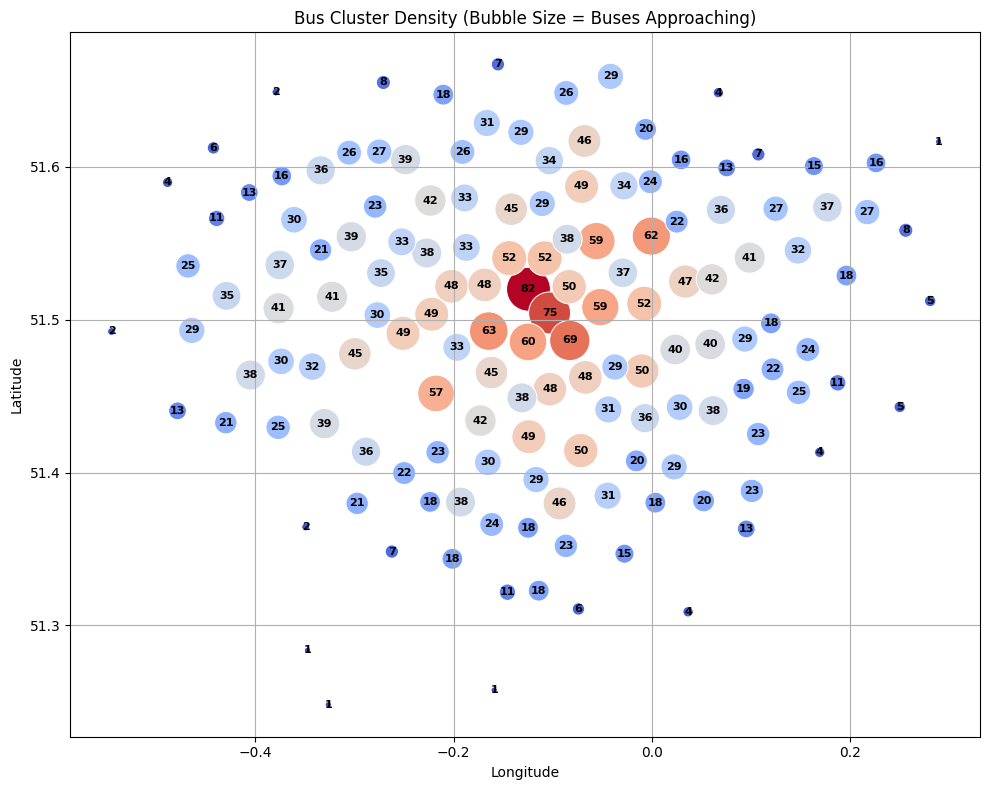

In [411]:

plt.figure(figsize=(10, 8))

# Bubble plot
sns.scatterplot(
    data=final_arrivals_pred_df_enriched_grouped,
    x='longitude',
    y='latitude',
    size='buses_approaching',
    sizes=(20, 1000),
    hue='buses_approaching',
    palette='coolwarm',
    legend=False
)

# Add text labels for each point
for _, row in final_arrivals_pred_df_enriched_grouped.iterrows():
    plt.text(
        row['longitude'],
        row['latitude'],
        str(round(row['buses_approaching'])),
        fontsize=8,
        ha='center',
        va='center',
        color='black',        
        weight='bold'
    )

plt.title("Bus Cluster Density (Bubble Size = Buses Approaching)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()
